In [1]:
import pandas as pd
import numpy as np
import sys
import os
import datetime as dt
sys.path.append('./Others/Data_Science/Project')

In [2]:
Temp2023 = pd.read_csv('Temp2023.csv', encoding='cp949')
Temp2024 = pd.read_csv('Temp2024.csv', encoding='cp949')
Temp2022 = pd.read_csv('Temp2022.csv', encoding='cp949')
Temp2021 = pd.read_csv('Temp2021.csv', encoding='cp949')
Temp2020 = pd.read_csv('Temp2020.csv', encoding='cp949')
Temp2019 = pd.read_csv('Temp2019.csv', encoding='cp949')
Temp2018 = pd.read_csv('Temp2018.csv', encoding='cp949')

In [3]:

sub2023 = pd.read_csv('sub2023.csv', encoding='cp949')

sub2024 = pd.read_csv('sub2024.csv', encoding='cp949')
sub2022 = pd.read_csv('sub2022.csv', encoding='cp949')
sub2021 = pd.read_csv('sub2021.csv', encoding='cp949')
sub2020 = pd.read_csv('sub2020.csv', encoding='cp949')
sub2019 = pd.read_excel('sub2019.xlsx', engine='openpyxl')
sub2018 = pd.read_excel('sub2018.xlsx', engine='openpyxl')

/tmp/ipykernel_1451/613545674.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  sub2022 = pd.read_csv('sub2022.csv', encoding='cp949')


In [4]:
sub2019.columns.values

array(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7',
       'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', '(단위:명)'], dtype=object)

In [5]:
sub2022 = sub2022.rename(columns={'고유역번호(외부역코드)': '역번호'})
sub2021 = sub2021.rename(columns = {'날짜' : '수송일자', '구분':'승하차구분'})
sub2020 = sub2020.rename(columns = {'날짜' : '수송일자', '구분':'승하차구분'})

columns = sub2018.iloc[0].values
sub2019.columns = columns
sub2019 = sub2019.iloc[1:].reset_index(drop=True)
sub2018.columns = columns
sub2018 = sub2018.iloc[1:].reset_index(drop=True)
sub2019 = sub2019.rename(columns = {'날짜' : '수송일자', '구분':'승하차구분'})
sub2018 = sub2018.rename(columns = {'날짜' : '수송일자', '구분':'승하차구분'})

In [6]:
sub2018.drop(columns = ['합 계'], inplace=True)
sub2019.drop(columns = ['합 계'], inplace=True)

In [7]:
def create_trainingset(Tempdat, subdat, stnstart, stn):
    # input : Tempdat - 일시, 기온(°C), 강수량(mm)
    #          subdat - 일자, 시간(가로축), 승하차구분, 호선, 승차인원
    # output : Df - 일자, 시간, 기온(°C), 강수량(mm), 승하차구분, 호선, 승차인원
    Temparr = Tempdat[['일시','기온(°C)','강수량(mm)']] 
    Temparr['일시'] = pd.to_datetime(Temparr['일시'])
    Temparr['강수량(mm)'] = Temparr['강수량(mm)'].fillna(0)
    # subdat은 6시이전 ~ 24시까지이므로 1,2,3,4시 데이터를 Tempdat에서 제외
    hours_to_exclude = [1, 2, 3, 4]
    Temparr = Temparr[~Temparr['일시'].dt.hour.isin(hours_to_exclude)]
    Temparr['시간'] = Temparr['일시'].dt.hour
    Temparr['일시'] = Temparr['일시'].dt.date
    # Temp의 1월 1일 00시 데이터 제거
    Temparr = Temparr.drop(Temparr.index[0])
    
    subdat_stn = subdat[(subdat['역명']==stn)] # stn에 해당하는 역 데이터만 추출출
    subdat_stn['수송일자'] = pd.to_datetime(subdat_stn['수송일자'])
    passenger = subdat_stn.iloc[:,stnstart:].values.flatten() # 승차인원의 시간별 데이터를 세로로 펴기기
    hour = np.arange(0,len(passenger)) % 20 + 5 # 시간은 5시부터 시작하므로 0~19를 5~24로 변환
    hour[hour == 24] = 0 # 24시를 0시로 변환
    
    # subdat_stn에서 시간을 세로축에 넣어 데이터를 재구성, 5시~24시까지의 데이터가 추가되므로 20개씩 반복복
    subdat_stn_New = pd.DataFrame({
        '일자': subdat_stn['수송일자'].values.repeat(20),
        '시간': hour,
        '역번호' : subdat_stn['역번호'].values.repeat(20),
        '승하차구분' : subdat_stn['승하차구분'].values.repeat(20),
        '호선' : subdat_stn['호선'].values.repeat(20),
        '승차인원': passenger
    })
    # 24시의 일자를 다음날로 변경 (예: 2023-01-01 24시 -> 2023-01-02 00시)
    mask = subdat_stn_New['시간'] == 0
    subdat_stn_New.loc[mask, '일자'] = subdat_stn_New.loc[mask, '일자'] + pd.Timedelta(days=1)
    # subdat_stn_New의 일자를 date 타입으로 변환 (비교를 위해)
    subdat_stn_New['일자'] = subdat_stn_New['일자'].dt.date

    # 일자와 시간을 기준으로 left join
    subdat_stn_New_arr = subdat_stn_New.merge(
        Temparr,
        left_on=['일자', '시간'],
        right_on=['일시', '시간'],
        how='left'
    )
    subdat_stn_New_arr = subdat_stn_New_arr.drop(columns=['일시'])
    subdat_stn_New_arr['일자'] = pd.to_datetime(subdat_stn_New_arr['일자'])
    subdat_stn_New_arr = subdat_stn_New_arr.dropna()
    # 주말과 휴일 기입, 주말 = 1, 휴일 = 2, 주말인데 휴일인 날도 2로 처리
    weekend = subdat_stn_New_arr['일자'].dt.weekday >=5
    subdat_stn_New_arr['주말'] = 0
    subdat_stn_New_arr['주말'][weekend]=1
    vacation_2023 = np.array([dt.date(2023,1,1), dt.date(2023,1,21), dt.date(2023,1,22), dt.date(2023,1,23),
                     dt.date(2023,1,24), dt.date(2023,3,1), dt.date(2023,5,5),dt.date(2023,5,27),
                     dt.date(2023,5,29), dt.date(2023,6,6), dt.date(2023,8,15),
                     dt.date(2023,9,28), dt.date(2023,9,29), dt.date(2023,9,30),
                      dt.date(2023,10,2), dt.date(2023,10,3),dt.date(2023,10,9),
                      dt.date(2023,12,25)])
    vacation_2024 = np.array([dt.date(2024,1,1),dt.date(2024,2,9), dt.date(2024,2,10),
                            dt.date(2024,2,11),dt.date(2024,2,12),
                            dt.date(2024,3,1),dt.date(2024,4,10),dt.date(2024,5,5),
                            dt.date(2024,5,6),dt.date(2024,5,15),dt.date(2024,6,6),
                            dt.date(2024,8,15),dt.date(2024,9,16), dt.date(2024,9,17),
                            dt.date(2024,9,18),dt.date(2024,10,3),dt.date(2024,10,9),
                            dt.date(2024,12,25)])
    vacation_2022 = np.array([dt.date(2022,1,1), dt.date(2022,1,31), dt.date(2022,2,1),
                    dt.date(2022,2,2), dt.date(2022,3,1), dt.date(2022,3,9),
                    dt.date(2022,5,5), dt.date(2022,5,8), dt.date(2022,6,1),dt.date(2022,6,6),
                    dt.date(2022,8,15), dt.date(2022,9,9), dt.date(2022,9,10),
                    dt.date(2022,9,11), dt.date(2022,9,12), dt.date(2022,10,3),
                    dt.date(2022,10,9),dt.date(2022,10,10), dt.date(2022,12,25)])
    vacation_2021 = np.array([dt.date(2021,1,1), dt.date(2021,2,11), dt.date(2021,2,12),
                              dt.date(2021,2,13), dt.date(2021,3,1), dt.date(2021,5,5),
                              dt.date(2021,5,19),dt.date(2021,6,6),dt.date(2021,8,15),
                              dt.date(2021,9,20), dt.date(2021,9,21), dt.date(2021,9,22),
                              dt.date(2021,10,3), dt.date(2021,10,9),
                              dt.date(2021,12,25)])
    vacation_2020 = np.array([dt.date(2020,1,1), dt.date(2020,1,24), dt.date(2020,1,25),
                              dt.date(2020,1,26), dt.date(2020,3,1), dt.date(2020,4,15),
                              dt.date(2020,4,30), dt.date(2020,5,5), dt.date(2020,6,6),
                              dt.date(2020,8,15), dt.date(2020,9,30), dt.date(2020,10,1),
                                dt.date(2020,10,2), dt.date(2020,10,3), dt.date(2020,10,9),
                                dt.date(2020,12,25)])
    vacation_2019 = np.array([dt.date(2019,1,1), dt.date(2019,2,4), dt.date(2019,2,5),
                              dt.date(2019,2,6), dt.date(2019,3,1), dt.date(2019,5,5),
                              dt.date(2019,5,6), dt.date(2019,5,12), dt.date(2019,6,6),
                              dt.date(2019,8,15), dt.date(2019,9,12), dt.date(2019,9,13),
                              dt.date(2019,9,14), dt.date(2019,10,3), dt.date(2019,10,9),
                              dt.date(2019,12,25)])
    vacation_2018 = np.array([dt.date(2018,1,1), dt.date(2018,2,15), dt.date(2018,2,16),
                            dt.date(2018,2,17), dt.date(2018,3,1), dt.date(2018,5,5),
                            dt.date(2018,5,22), dt.date(2018,6,6), dt.date(2018,8,15),
                            dt.date(2018,9,24), dt.date(2018,9,25), dt.date(2018,9,23),
                            dt.date(2018,10,3), dt.date(2018,10,9), dt.date(2018,12,25)])
    
    if subdat_stn_New_arr['일자'].dt.year.min() == 2023:
        subdat_stn_New_arr['주말'][subdat_stn_New_arr['일자'].dt.date.isin(vacation_2023)] = 2 #
    elif subdat_stn_New_arr['일자'].dt.year.min() == 2024:
        subdat_stn_New_arr['주말'][subdat_stn_New_arr['일자'].dt.date.isin(vacation_2024)] = 2
    elif subdat_stn_New_arr['일자'].dt.year.min() == 2022:
        subdat_stn_New_arr['주말'][subdat_stn_New_arr['일자'].dt.date.isin(vacation_2022)] = 2
    elif subdat_stn_New_arr['일자'].dt.year.min() == 2021:
        subdat_stn_New_arr['주말'][subdat_stn_New_arr['일자'].dt.date.isin(vacation_2021)] = 2
    elif subdat_stn_New_arr['일자'].dt.year.min() == 2020:
        subdat_stn_New_arr['주말'][subdat_stn_New_arr['일자'].dt.date.isin(vacation_2020)] = 2
    elif subdat_stn_New_arr['일자'].dt.year.min() == 2019:
        subdat_stn_New_arr['주말'][subdat_stn_New_arr['일자'].dt.date.isin(vacation_2019)] = 2
    else:
        subdat_stn_New_arr['주말'][subdat_stn_New_arr['일자'].dt.date.isin(vacation_2018)] = 2
    return subdat_stn_New_arr

# 천호(풍납토성)

In [ ]:
df1 = create_trainingset(Temp2023, sub2023, 6,'천호(풍납토성)')
df2 = create_trainingset(Temp2024, sub2024,6, '천호(풍납토성)')
df3 = create_trainingset(Temp2022, sub2022, 6,'천호(풍납토성)')
df_ml = pd.concat([df1, df2, df3], ignore_index=True)

In [9]:
# ...existing code...
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 범주형 변수 인코딩
#df_ml['승차인원'] = np.log10(df_ml['승차인원']+1)  # 승차인원 로그 변환
df_ml['승하차구분'] = df_ml['승하차구분'].astype('category').cat.codes
df_ml['호선'] = df_ml['호선'].astype('category').cat.codes

# 입력 변수와 출력 변수 지정
#X = df_ml[['시간', '승하차구분','기온(°C)', '강수량(mm)', '주말', '호선']]
X = df_ml[['시간', '승하차구분','기온(°C)', '강수량(mm)', '호선']]
#X = df_ml[['시간', '승하차구분', '주말', '호선']]
y = df_ml['승차인원']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 11, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# 기본 랜덤 포레스트 모델
rf = RandomForestRegressor(random_state=42)

# GridSearchCV 설정
# CV는 Cross-validation 폴드 수, n_jobs=-1은 모든 CPU 코어 사용
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, 
                           n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# GridSearchCV를 사용한 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델로 예측 및 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
#mse = mean_squared_error(10**y_test-1, 10**y_pred-1)
print(f"튜닝 후 테스트 MSE: {np.sqrt(mse):.2f}")

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   4.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   8.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   8.4s
[CV] END max_dept

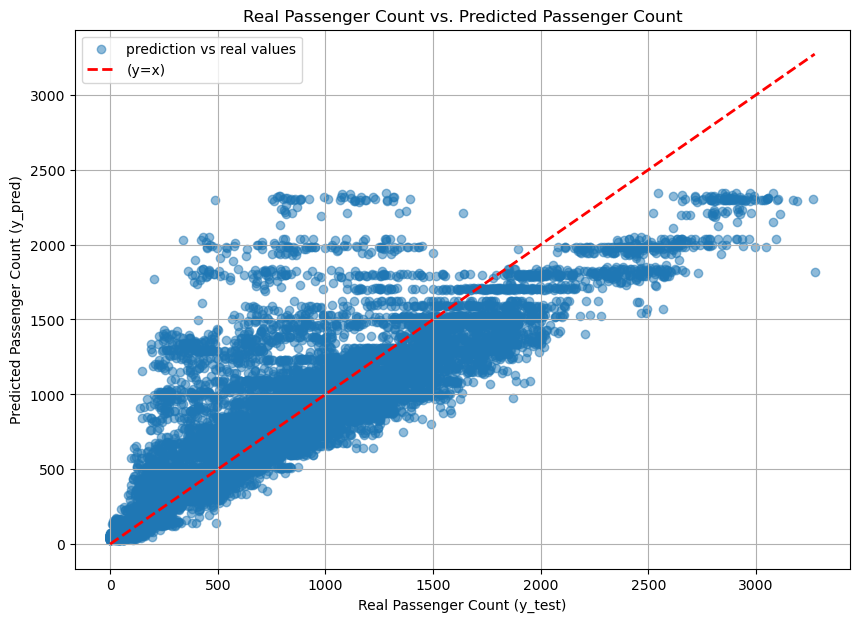

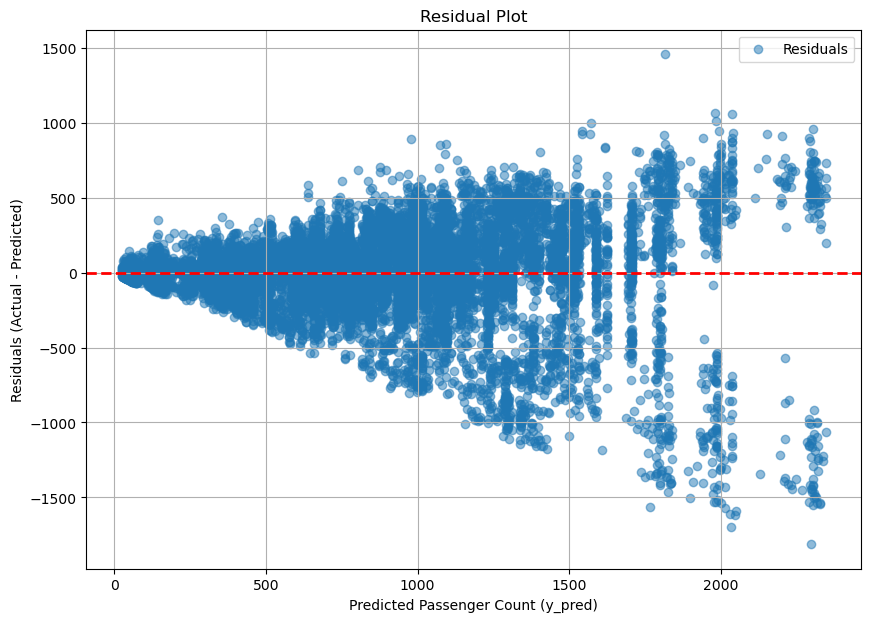

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# y_test와 y_pred가 이전 셀에서 이미 정의되었다고 가정합니다.
# (예: cell id '7279279a' 또는 'a0719358' 이후)

plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, alpha=0.5, label='prediction vs real values')
plt.xlabel("Real Passenger Count (y_test)")
plt.ylabel("Predicted Passenger Count (y_pred)")
plt.title("Real Passenger Count vs. Predicted Passenger Count")

# 완벽한 예측선을 위한 대각선 추가
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='(y=x)')

plt.legend()
plt.grid(True)
plt.show()

# 추가적으로 잔차도(Residual Plot)도 유용합니다.
# 잔차 = 실제 값 - 예측 값
residuals = y_test - y_pred

plt.figure(figsize=(10, 7))
plt.scatter(y_pred, residuals, alpha=0.5, label='Residuals')
plt.xlabel("Predicted Passenger Count (y_pred)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--', lw=2) # 기준선
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
new_X = pd.DataFrame([[13, 1, 0, 0.9, 0, 0]], columns=['시간', '승하차구분', '호선', '기온(°C)', '강수량(mm)', '주말'])
pred_y = bp_gangnam.predict(new_X)
print(f"예측된 승차인원: {pred_y[0]:.0f}") 

# 노원

/tmp/ipykernel_2678/1642521845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temparr['일시'] = pd.to_datetime(Temparr['일시'])
/tmp/ipykernel_2678/1642521845.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temparr['강수량(mm)'] = Temparr['강수량(mm)'].fillna(0)
/tmp/ipykernel_2678/1642521845.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END max_dept

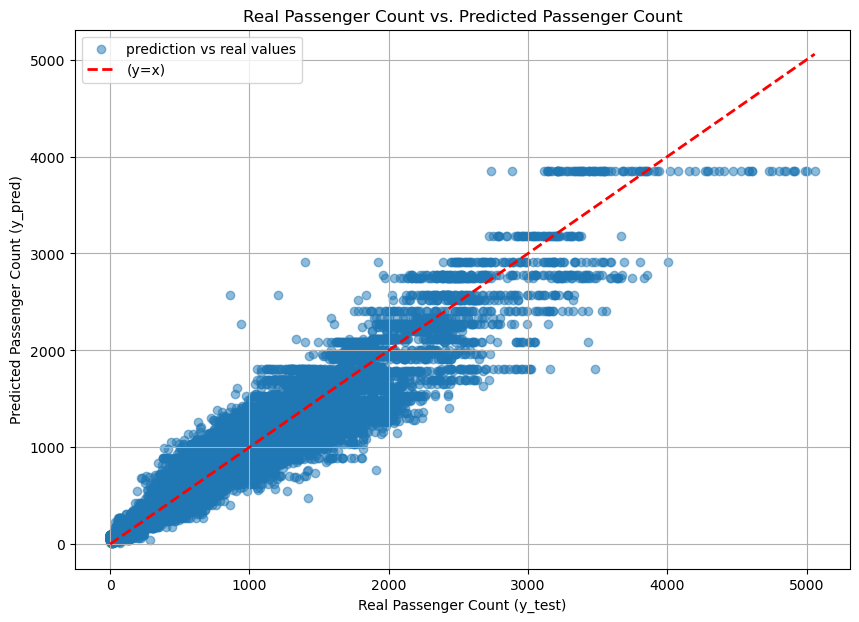

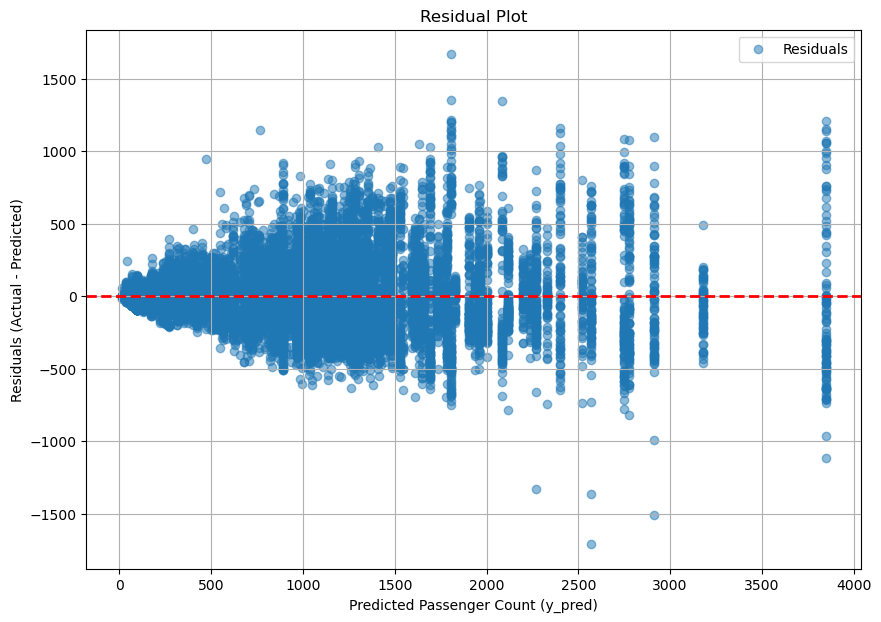

In [ ]:
df1 = create_trainingset(Temp2023, sub2023, 6,'노원')
df2 = create_trainingset(Temp2024, sub2024,6, '노원')
df3 = create_trainingset(Temp2022, sub2022, 6,'노원')
df_ml = pd.concat([df1, df2, df3], ignore_index=True)
# ...existing code...
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 범주형 변수 인코딩
#df_ml['승차인원'] = np.log10(df_ml['승차인원']+1)  # 승차인원 로그 변환
df_ml['승하차구분'] = df_ml['승하차구분'].astype('category').cat.codes
df_ml['호선'] = df_ml['호선'].astype('category').cat.codes

# 입력 변수와 출력 변수 지정
#X = df_ml[['시간', '승하차구분','기온(°C)', '강수량(mm)', '주말', '호선']]
X = df_ml[['시간', '승하차구분','기온(°C)', '강수량(mm)', '호선']]
#X = df_ml[['시간', '승하차구분', '주말', '호선']]
y = df_ml['승차인원']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 11, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# 기본 랜덤 포레스트 모델
rf = RandomForestRegressor(random_state=42)

# GridSearchCV 설정
# CV는 Cross-validation 폴드 수, n_jobs=-1은 모든 CPU 코어 사용
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, 
                           n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# GridSearchCV를 사용한 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델로 예측 및 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
#mse = mean_squared_error(10**y_test-1, 10**y_pred-1)
print(f"튜닝 후 테스트 MSE: {np.sqrt(mse):.2f}")
import matplotlib.pyplot as plt
import numpy as np

# y_test와 y_pred가 이전 셀에서 이미 정의되었다고 가정합니다.
# (예: cell id '7279279a' 또는 'a0719358' 이후)

plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, alpha=0.5, label='prediction vs real values')
plt.xlabel("Real Passenger Count (y_test)")
plt.ylabel("Predicted Passenger Count (y_pred)")
plt.title("Real Passenger Count vs. Predicted Passenger Count")

# 완벽한 예측선을 위한 대각선 추가
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='(y=x)')

plt.legend()
plt.grid(True)
plt.show()

# 추가적으로 잔차도(Residual Plot)도 유용합니다.
# 잔차 = 실제 값 - 예측 값
residuals = y_test - y_pred

plt.figure(figsize=(10, 7))
plt.scatter(y_pred, residuals, alpha=0.5, label='Residuals')
plt.xlabel("Predicted Passenger Count (y_pred)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--', lw=2) # 기준선
plt.legend()
plt.grid(True)
plt.show()

# 강남

/tmp/ipykernel_1451/1642521845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temparr['일시'] = pd.to_datetime(Temparr['일시'])
/tmp/ipykernel_1451/1642521845.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temparr['강수량(mm)'] = Temparr['강수량(mm)'].fillna(0)
/tmp/ipykernel_1451/1642521845.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END max_dept

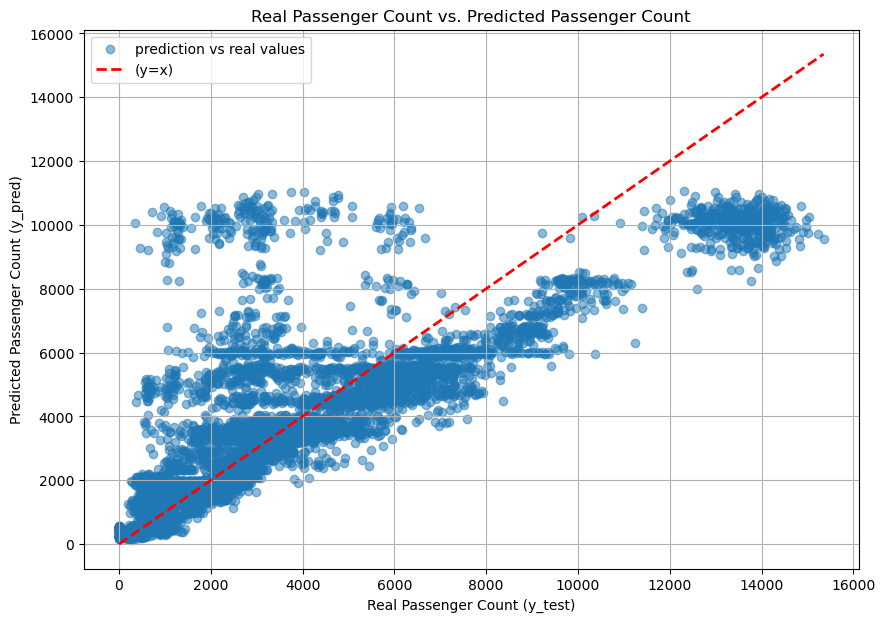

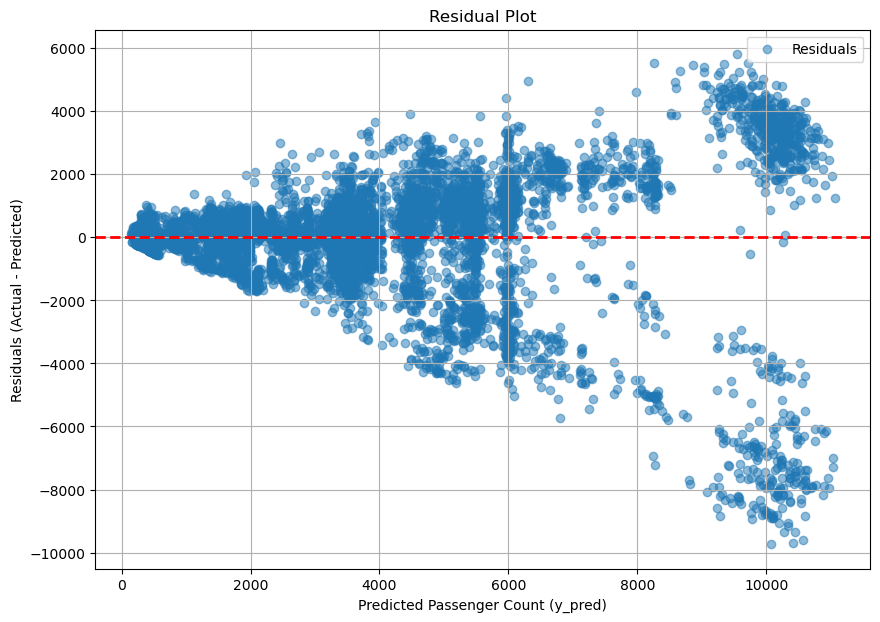

In [12]:
df1 = create_trainingset(Temp2023, sub2023, 6,'강남')
df2 = create_trainingset(Temp2024, sub2024,6, '강남')
df3 = create_trainingset(Temp2022, sub2022, 6,'강남')
df_ml = pd.concat([df1, df2, df3], ignore_index=True)
# ...existing code...
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 범주형 변수 인코딩
#df_ml['승차인원'] = np.log10(df_ml['승차인원']+1)  # 승차인원 로그 변환
df_ml['승하차구분'] = df_ml['승하차구분'].astype('category').cat.codes
df_ml['호선'] = df_ml['호선'].astype('category').cat.codes

# 입력 변수와 출력 변수 지정
#X = df_ml[['시간', '승하차구분','기온(°C)', '강수량(mm)', '주말', '호선']]
X = df_ml[['시간', '승하차구분','기온(°C)', '강수량(mm)', '호선']]
#X = df_ml[['시간', '승하차구분', '주말', '호선']]
y = df_ml['승차인원']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 11, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# 기본 랜덤 포레스트 모델
rf = RandomForestRegressor(random_state=42)

# GridSearchCV 설정
# CV는 Cross-validation 폴드 수, n_jobs=-1은 모든 CPU 코어 사용
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, 
                           n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# GridSearchCV를 사용한 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델로 예측 및 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
#mse = mean_squared_error(10**y_test-1, 10**y_pred-1)
print(f"튜닝 후 테스트 MSE: {np.sqrt(mse):.2f}")
import matplotlib.pyplot as plt
import numpy as np

# y_test와 y_pred가 이전 셀에서 이미 정의되었다고 가정합니다.
# (예: cell id '7279279a' 또는 'a0719358' 이후)

plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, alpha=0.5, label='prediction vs real values')
plt.xlabel("Real Passenger Count (y_test)")
plt.ylabel("Predicted Passenger Count (y_pred)")
plt.title("Real Passenger Count vs. Predicted Passenger Count")

# 완벽한 예측선을 위한 대각선 추가
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='(y=x)')

plt.legend()
plt.grid(True)
plt.show()

# 추가적으로 잔차도(Residual Plot)도 유용합니다.
# 잔차 = 실제 값 - 예측 값
residuals = y_test - y_pred

plt.figure(figsize=(10, 7))
plt.scatter(y_pred, residuals, alpha=0.5, label='Residuals')
plt.xlabel("Predicted Passenger Count (y_pred)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--', lw=2) # 기준선
plt.legend()
plt.grid(True)
plt.show()

# 고속터미널

/tmp/ipykernel_2678/1642521845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temparr['일시'] = pd.to_datetime(Temparr['일시'])
/tmp/ipykernel_2678/1642521845.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temparr['강수량(mm)'] = Temparr['강수량(mm)'].fillna(0)
/tmp/ipykernel_2678/1642521845.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_dept

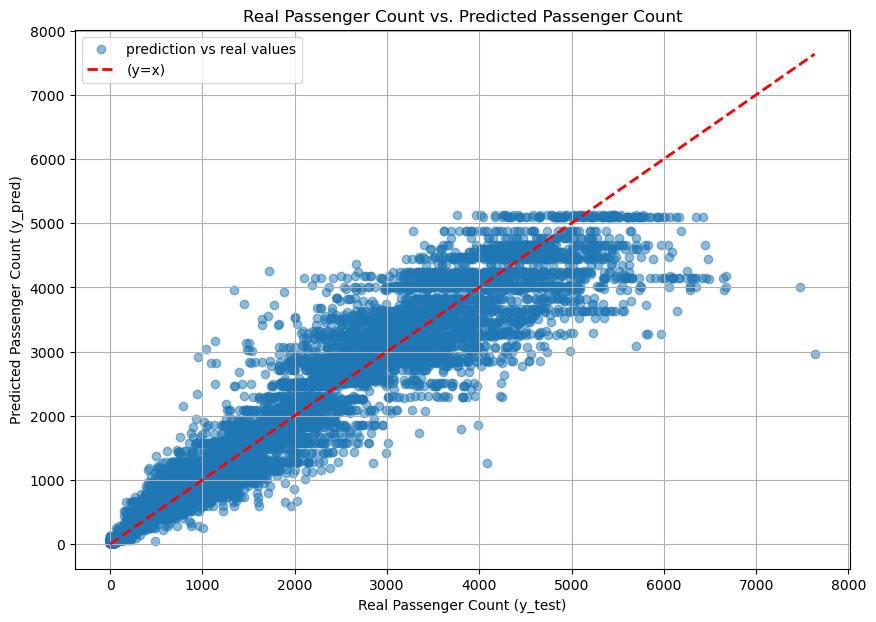

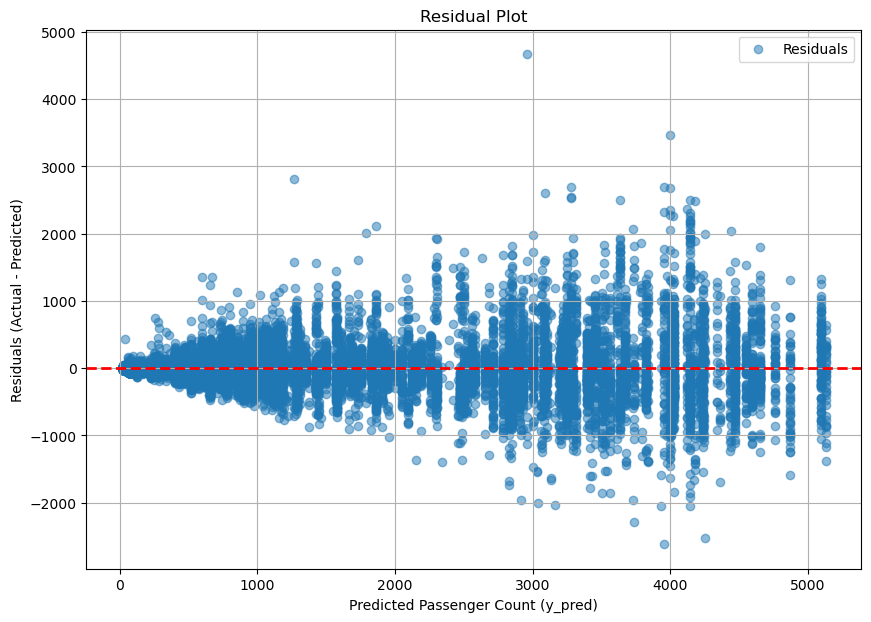

In [121]:
df1 = create_trainingset(Temp2023, sub2023, 6,'고속터미널')
df2 = create_trainingset(Temp2024, sub2024,6, '고속터미널')
df3 = create_trainingset(Temp2022, sub2022, 6,'고속터미널')
df_ml = pd.concat([df1, df2, df3], ignore_index=True)
# ...existing code...
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 범주형 변수 인코딩
#df_ml['승차인원'] = np.log10(df_ml['승차인원']+1)  # 승차인원 로그 변환
df_ml['승하차구분'] = df_ml['승하차구분'].astype('category').cat.codes
df_ml['호선'] = df_ml['호선'].astype('category').cat.codes

# 입력 변수와 출력 변수 지정
#X = df_ml[['시간', '승하차구분','기온(°C)', '강수량(mm)', '주말', '호선']]
X = df_ml[['시간', '승하차구분', '주말', '호선']]
y = df_ml['승차인원']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 11, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# 기본 랜덤 포레스트 모델
rf = RandomForestRegressor(random_state=42)

# GridSearchCV 설정
# CV는 Cross-validation 폴드 수, n_jobs=-1은 모든 CPU 코어 사용
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, 
                           n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# GridSearchCV를 사용한 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델로 예측 및 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
#mse = mean_squared_error(10**y_test-1, 10**y_pred-1)
print(f"튜닝 후 테스트 MSE: {np.sqrt(mse):.2f}")
import matplotlib.pyplot as plt
import numpy as np

# y_test와 y_pred가 이전 셀에서 이미 정의되었다고 가정합니다.
# (예: cell id '7279279a' 또는 'a0719358' 이후)

plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, alpha=0.5, label='prediction vs real values')
plt.xlabel("Real Passenger Count (y_test)")
plt.ylabel("Predicted Passenger Count (y_pred)")
plt.title("Real Passenger Count vs. Predicted Passenger Count")

# 완벽한 예측선을 위한 대각선 추가
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='(y=x)')

plt.legend()
plt.grid(True)
plt.show()

# 추가적으로 잔차도(Residual Plot)도 유용합니다.
# 잔차 = 실제 값 - 예측 값
residuals = y_test - y_pred

plt.figure(figsize=(10, 7))
plt.scatter(y_pred, residuals, alpha=0.5, label='Residuals')
plt.xlabel("Predicted Passenger Count (y_pred)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--', lw=2) # 기준선
plt.legend()
plt.grid(True)
plt.show()

# 홍대입구

/tmp/ipykernel_1451/1642521845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temparr['일시'] = pd.to_datetime(Temparr['일시'])
/tmp/ipykernel_1451/1642521845.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temparr['강수량(mm)'] = Temparr['강수량(mm)'].fillna(0)
/tmp/ipykernel_1451/1642521845.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_dept

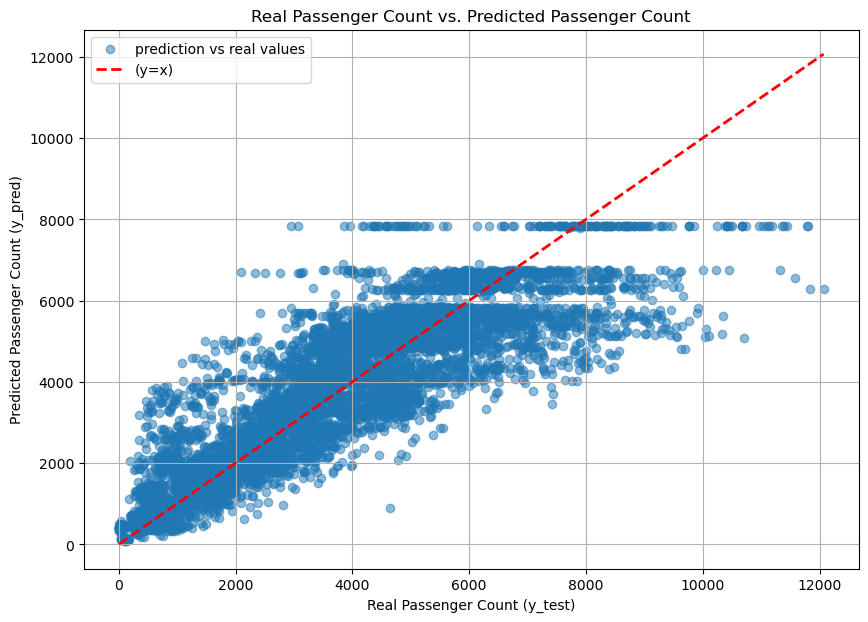

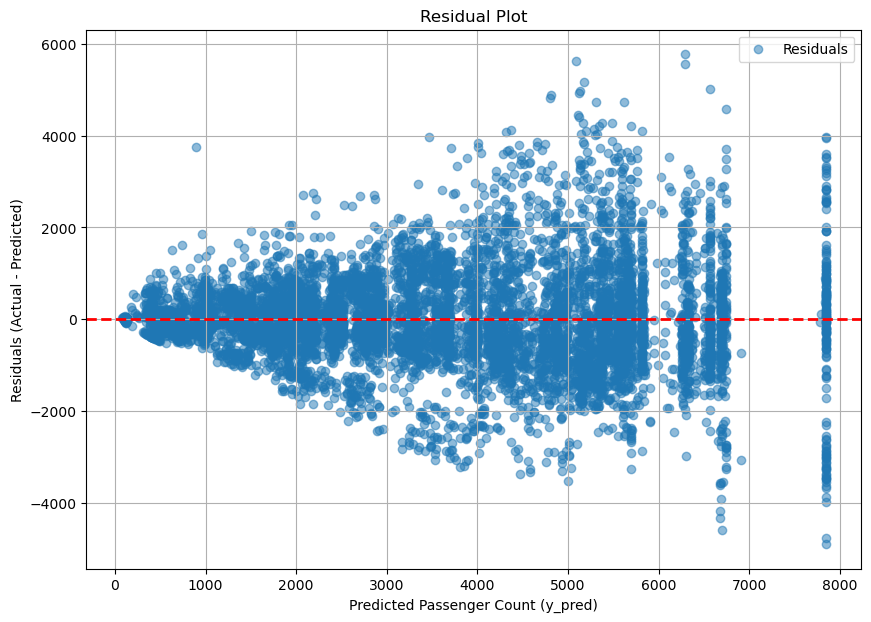

In [13]:
df1 = create_trainingset(Temp2023, sub2023, 6,'홍대입구')
df2 = create_trainingset(Temp2024, sub2024,6, '홍대입구')
df3 = create_trainingset(Temp2022, sub2022, 6,'홍대입구')
df_ml = pd.concat([df1, df2, df3], ignore_index=True)
# ...existing code...
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 범주형 변수 인코딩
#df_ml['승차인원'] = np.log10(df_ml['승차인원']+1)  # 승차인원 로그 변환
df_ml['승하차구분'] = df_ml['승하차구분'].astype('category').cat.codes
df_ml['호선'] = df_ml['호선'].astype('category').cat.codes

# 입력 변수와 출력 변수 지정
#X = df_ml[['시간', '승하차구분','기온(°C)', '강수량(mm)', '주말', '호선']]
X = df_ml[['시간', '승하차구분','기온(°C)', '강수량(mm)', '호선']]
#X = df_ml[['시간', '승하차구분', '주말', '호선']]
y = df_ml['승차인원']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 11, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# 기본 랜덤 포레스트 모델
rf = RandomForestRegressor(random_state=42)

# GridSearchCV 설정
# CV는 Cross-validation 폴드 수, n_jobs=-1은 모든 CPU 코어 사용
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, 
                           n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# GridSearchCV를 사용한 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델로 예측 및 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
#mse = mean_squared_error(10**y_test-1, 10**y_pred-1)
print(f"튜닝 후 테스트 MSE: {np.sqrt(mse):.2f}")
import matplotlib.pyplot as plt
import numpy as np

# y_test와 y_pred가 이전 셀에서 이미 정의되었다고 가정합니다.
# (예: cell id '7279279a' 또는 'a0719358' 이후)

plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, alpha=0.5, label='prediction vs real values')
plt.xlabel("Real Passenger Count (y_test)")
plt.ylabel("Predicted Passenger Count (y_pred)")
plt.title("Real Passenger Count vs. Predicted Passenger Count")

# 완벽한 예측선을 위한 대각선 추가
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='(y=x)')

plt.legend()
plt.grid(True)
plt.show()

# 추가적으로 잔차도(Residual Plot)도 유용합니다.
# 잔차 = 실제 값 - 예측 값
residuals = y_test - y_pred

plt.figure(figsize=(10, 7))
plt.scatter(y_pred, residuals, alpha=0.5, label='Residuals')
plt.xlabel("Predicted Passenger Count (y_pred)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--', lw=2) # 기준선
plt.legend()
plt.grid(True)
plt.show()

# 데이터 분석

In [26]:
test1 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==2) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']==0)]['승차인원']
from scipy.stats import anderson
result = anderson(test1)
result.statistic, result.critical_values, result.significance_level

(0.6351547341855834,
 array([0.523, 0.596, 0.715, 0.834, 0.992]),
 array([15. , 10. ,  5. ,  2.5,  1. ]))

In [24]:
test2 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==1) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']==0)]['승차인원']
test3 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==0) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']==0)]['승차인원']
test4 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==2) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']>0)]['승차인원']
test5 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==1) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']>0)]['승차인원']
test6 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==0) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']>0)]['승차인원']

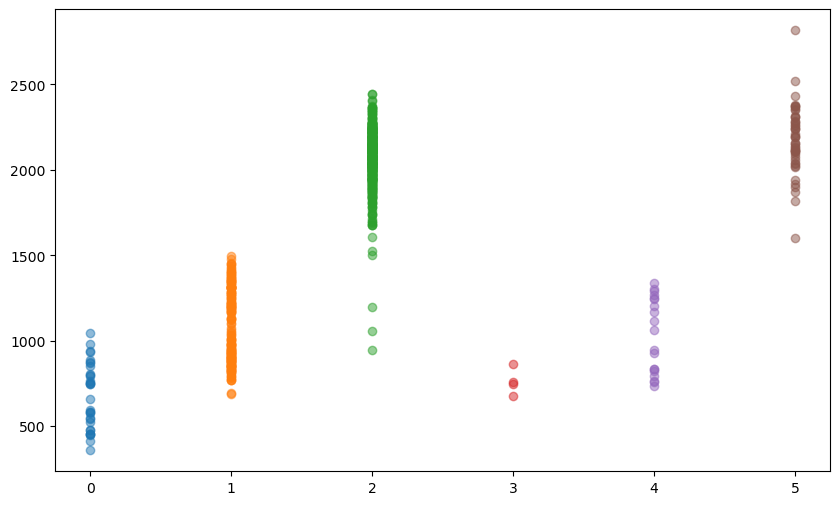

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(test1.values*0, test1.values, alpha=0.5)
plt.scatter(np.ones_like(test2), test2.values, alpha=0.5)
plt.scatter(np.ones_like(test3)*2, test3.values, alpha=0.5)
plt.scatter(np.ones_like(test4)*3, test4.values, alpha=0.5)
plt.scatter(np.ones_like(test5)*4, test5.values, alpha=0.5)
plt.scatter(np.ones_like(test6)*5, test6.values, alpha=0.5)

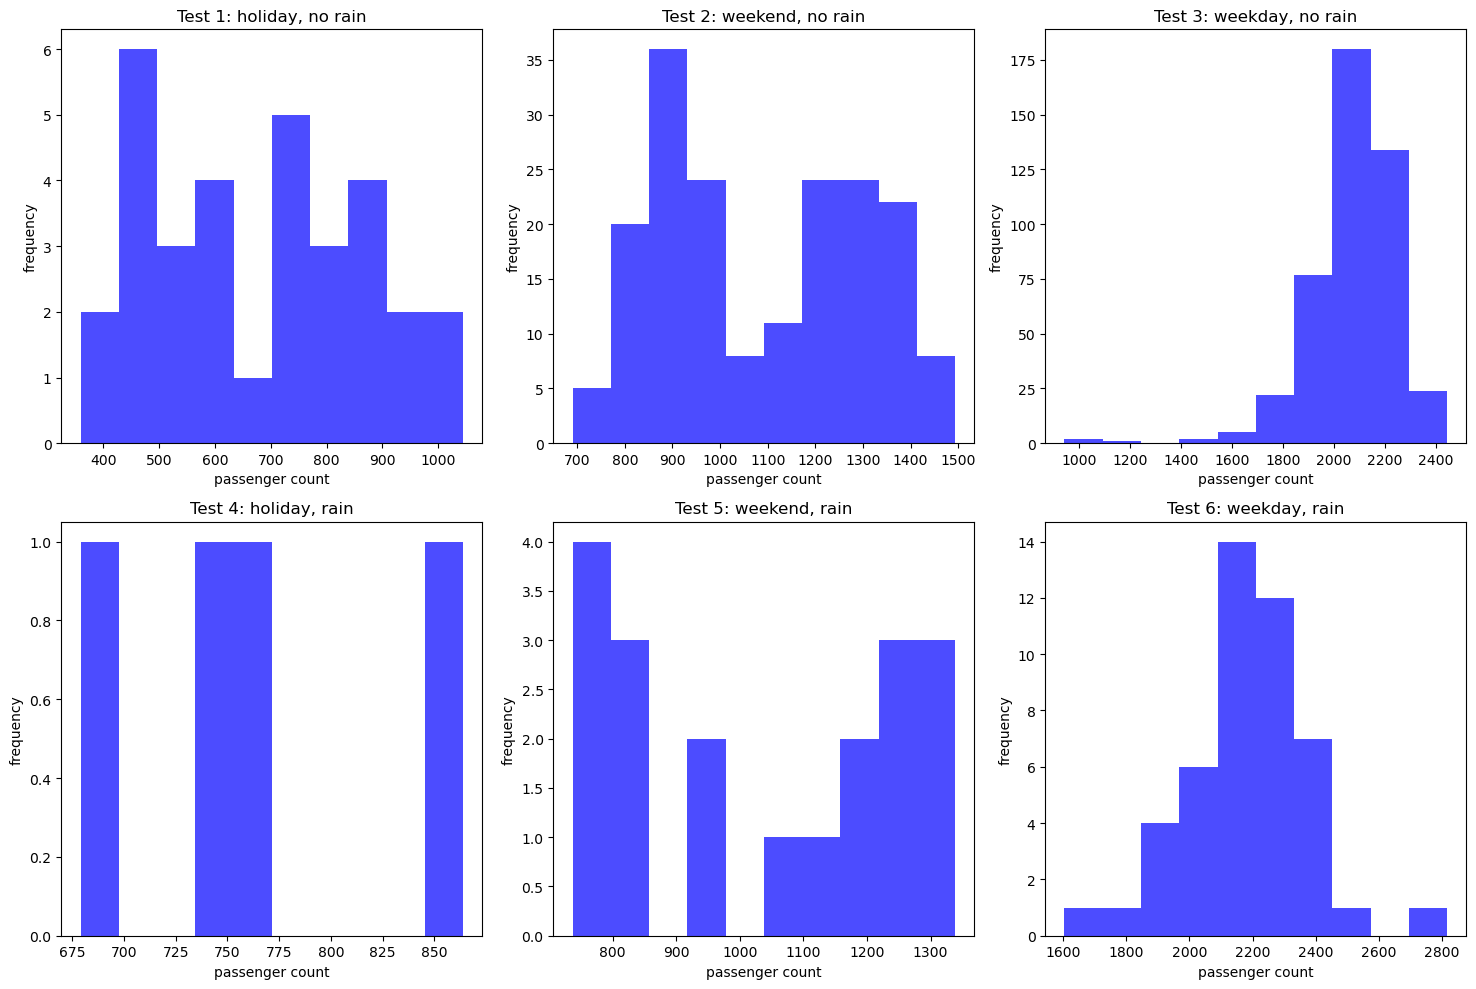

In [36]:


import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten() # 2x3 배열을 1차원 배열로 만듭니다.

datasets = [test1, test2, test3, test4, test5, test6]
titles = ['Test 1: holiday, no rain', 'Test 2: weekend, no rain', 'Test 3: weekday, no rain', 
          'Test 4: holiday, rain', 'Test 5: weekend, rain', 'Test 6: weekday, rain']

for i, data in enumerate(datasets):
    axes[i].hist(data, bins=10, alpha=0.7, color='blue')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('passenger count')
    axes[i].set_ylabel('frequency')

plt.tight_layout() # 서브플롯 간 간격 자동 조정
plt.show()
